In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


In [3]:
df=pd.read_csv("/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")

In [4]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
X=df[["Age","Annual Income (k$)","Spending Score (1-100)"]]

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler=StandardScaler()
x_scaled=scaler.fit_transform(X)

In [9]:
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster
import matplotlib.pyplot as plt 

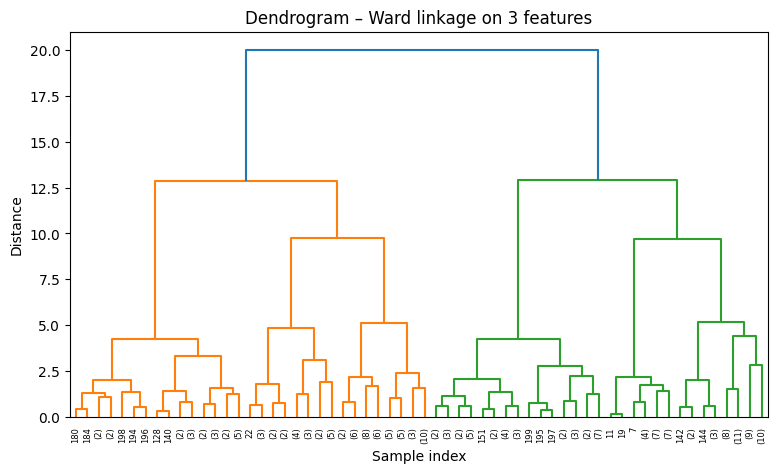

In [10]:
Z=linkage(x_scaled,method="ward")
plt.figure(figsize=(9,5))
dendrogram(Z,truncate_mode="level",p=5)
plt.title("Dendrogram – Ward linkage on 3 features")
plt.xlabel("Sample index"); plt.ylabel("Distance")
plt.show()


In [11]:
max_d=7.0
hc_lbl=fcluster(Z,max_d,criterion="distance") 
K_hc=hc_lbl.max()
K_hc


np.int32(6)

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
sil_scores={}
for k in range(2,11):
    km=KMeans(n_clusters=k,random_state=42,n_init="auto")
    labels=km.fit_predict(x_scaled)
    sil_scores[k]=silhouette_score(x_scaled,labels)
    best_k = max(sil_scores, key=sil_scores.get)
   
    

In [13]:
best_k

6

In [14]:
# Use the silhouette‑best if it differs by ≤1 from dendrogram,
# otherwise keep the dendrogram value

k_final = best_k if abs(best_k - K_hc) <= 1 else K_hc

In [17]:
init_centroids=np.vstack([x_scaled[hc_lbl==i].mean(axis=0) for i in range(1,k_final+1)]
                        )


In [19]:
kmeans=KMeans(n_clusters=k_final,init=init_centroids,random_state=42)
km_lbl=kmeans.fit_predict(x_scaled)
sil_km=silhouette_score(x_scaled,km_lbl)
sil_km

np.float64(0.429210925806494)

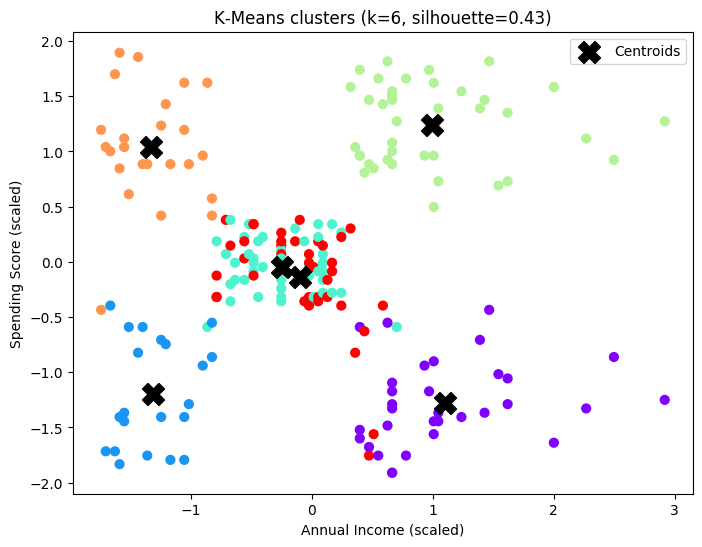

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
scatter = plt.scatter(x_scaled[:,1],          
                      x_scaled[:,2],           
                      c=km_lbl, cmap='rainbow', s=40)
plt.scatter(kmeans.cluster_centers_[:,1],
            kmeans.cluster_centers_[:,2],
            s=250, c='black', marker='X', label="Centroids")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.title(f"K‑Means clusters (k={k_final}, silhouette={sil_km:.2f})")
plt.legend()
plt.show()

In [23]:
df["Cluster"] = km_lbl
profile=(df.groupby("Cluster")[["Age", "Annual Income (k$)",
                                "Spending Score (1-100)"]] .mean()
                                                            .round(1))
profile

,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,
0,42.6,89.4,17.3
1,45.5,26.3,19.4
2,56.3,54.3,49.1
3,32.7,86.5,82.1
4,25.2,25.8,76.9
5,26.5,58.0,46.7
